In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import healpy as hp
import numpy as np
import pylab as pl
import camb 
import glob
rot = hp.Rotator(coord=['C','G'])
from astropy.coordinates import SkyCoord
from astropy.io import fits
import pymaster as nmt
import sys
from scipy import stats,interpolate
import copy
from camb import model, initialpower
from camb.sources import GaussianSourceWindow, SplinedSourceWindow
import astropy.constants as const

sys.path.append('/Users/gfabbian/Software/PolSpice_v03-07-05/bin')
sys.path.append('/Users/gfabbian/Work/quasar_gaia/gaia-quasars-lss/code/')

from lensing_qso_cross_utils import *

rot = hp.Rotator(coord=['C','G'])

nside = 512#256
lmax = 3*nside-1 #1200
zmin = 0.9
zmax = 2.2

In [3]:
def init_pars(do_magnification_bias=False):

    pars = camb.CAMBparams()
    lmax=1000
    
    pars.set_cosmology(H0=67.5, ombh2=0.02242, omch2=0.11933, mnu=0,tau=0.0561)
    As = np.e**3.047/1e10
    pars.InitPower.set_params(As=As, ns=0.9665)
    pars.set_for_lmax(lmax, lens_potential_accuracy=4)
    ##set Want_CMB to true if you also want CMB spectra or correlations
    pars.Want_CMB = True
    pars.WantTransfer=True
    
    ##NonLinear_both or NonLinear_lens will use non-linear corrections
    pars.NonLinear = model.NonLinear_both
    
    #density only is the default
    pars.SourceTerms.limber_windows = True
    pars.SourceTerms.limber_phi_lmin = 1#300
    pars.SourceTerms.counts_lensing = do_magnification_bias  
    pars.SourceTerms.counts_density  = True
    pars.SourceTerms.counts_redshift = False#True #weird problems at times
    pars.SourceTerms.counts_radial   = False#True # negligible at l<10
    pars.SourceTerms.counts_timedelay = False#True # negligible
    pars.SourceTerms.counts_ISW = False#True #negligible
    pars.SourceTerms.counts_velocity = False#True #negligible
    pars.SourceTerms.counts_potential = False#True #negligible
    pars.SourceTerms.counts_evolve = False#True # not sure what this is
    
    pars.Accuracy.LensingBoost = 1.0
    pars.Accuracy.NonlinSourceBoost = 1.0
    pars.Accuracy.BesselBoost = 1.0
    pars.Accuracy.LimberBoost = 1.0
    pars.Accuracy.SourceLimberBoost = 1.0
    return pars 

# Data
### CMB lensing

In [4]:
klm = hp.read_alm('/Users/gfabbian/Work/PR4_variations/PR42018like_klm_dat_MV.fits') # read DR4 instead of DR3
clkk = hp.alm2cl(klm)

### Gaia QSO

In [5]:
d=fits.open('../../gaia_G20.0.fits')
nqso = len(d[1].data['redshift_spz'])
zcat=d[1].data['redshift_spz']
zmed = np.median(zcat)

bounds = np.percentile(zcat,[25,50,75])
mask_z1 = zcat<bounds[0]
mask_z2 = (zcat>=bounds[0])&(zcat<bounds[1])
mask_z3 = (zcat>=bounds[1])&(zcat<bounds[2])
mask_z4 = zcat>=bounds[2]
mask_z5 = zcat>=2.6

print("bounds tomographic bins",[0]+list(bounds)+[np.max(zcat)])
print("effective median redhisfts",np.median(zcat[mask_z1]),np.median(zcat[mask_z2]),np.median(zcat[mask_z3]),
      np.median(zcat[mask_z4]),np.median(zcat[mask_z5]))
print("effective mean redhisfts",np.mean(zcat[mask_z1]),np.mean(zcat[mask_z2]),np.mean(zcat[mask_z3]),
      np.mean(zcat[mask_z4]),np.mean(zcat[mask_z5]))

print("\nzmin",d[1].data['redshift_spz'].min(),"zmax",d[1].data['redshift_spz'].max())

bounds tomographic bins [0, 0.9440646171569824, 1.447939, 1.974499, 4.54]
effective median redhisfts 0.6200702520427703 1.201 1.6849333047866821 2.383 2.88
effective mean redhisfts 0.59904534876775 1.2025720962418147 1.6933676386481 2.4737030208453596 2.9648669544340454

zmin 0.06540057808160782 zmax 4.54


In [6]:
#Counts Stats on Kate's mask
#nbar         1.2225455565615475 mean/std counts map 0.8250452677408854 1.0337500142615053
#nbar selfun. 1.243099102737518 mean/std counts map 0.6197776065672138 1.0365438031703522
#
#Counts Stats on sky counts !=0
#nbar         1.6440989334826643
#nbar fsky=50 1.2208661305813255
#nbar selfun. 1.235054295558502

In [7]:
dndz1=np.histogram(zcat[mask_z1],bins=30,density=True)
dndz2=np.histogram(zcat[mask_z2],bins=30,density=True)
dndz3=np.histogram(zcat[mask_z3],bins=30,density=True)
dndz4=np.histogram(zcat[mask_z4],bins=30,density=True)
dndz5=np.histogram(zcat[mask_z5],bins=30,density=True)

dndz1=[np.diff(dndz1[1])/2+dndz1[1][:-1],dndz1[0]]
dndz2=[np.diff(dndz2[1])/2+dndz2[1][:-1],dndz2[0]]
dndz3=[np.diff(dndz3[1])/2+dndz3[1][:-1],dndz3[0]]
dndz4=[np.diff(dndz4[1])/2+dndz4[1][:-1],dndz4[0]]
dndz5=[np.diff(dndz5[1])/2+dndz5[1][:-1],dndz5[0]]
dndz1[1]/=np.trapz(dndz1[1],dndz1[0])
dndz2[1]/=np.trapz(dndz2[1],dndz2[0])
dndz3[1]/=np.trapz(dndz3[1],dndz3[0])
dndz4[1]/=np.trapz(dndz4[1],dndz4[0])
dndz5[1]/=np.trapz(dndz5[1],dndz5[0])

# integrated bin
dndz_spz= np.histogram(d[1].data['redshift_spz'],bins=50,density=True)
dndz=[np.diff(dndz_spz[1])/2+dndz_spz[1][:-1],dndz_spz[0]] 
dndz[1]/=np.trapz(dndz[1],dndz[0])
interp_dndz_gaia = interpolate.interp1d(dndz[0],dndz[1],fill_value=0.,bounds_error=False)

### SDSS

I apply the same cut as in Leistedt+2014 (https://arxiv.org/abs/1405.4315,https://arxiv.org/abs/1404.6530) and also consider a case where all the objects are included (with a small amount of objects in the range $4<z<7$). 

In [8]:
sdss=fits.open("../../sdss/DR16Q_v4.fits")

try:
    # select only safest QSO
    qso_mask = sdss[1].data['IS_QSO_FINAL']==1
except:
    qso_mask = np.ones(len(sdss[1].data['Z']),dtype=bool)
    
z_sdss=sdss[1].data['Z']

# follows cuts of Leistedt+2015 but higher z is also possible
zmin_sdss = 0.5
zmax_sdss = 3.5
zmask=(z_sdss>zmin_sdss) & (z_sdss<zmax_sdss)
zmask = zmask & qso_mask
zmask_all = (z_sdss>0) & qso_mask
#z_sdss=z_sdss[zmask]

nqso_sdss = np.sum(z_sdss[zmask])
nqso_sdss_all = np.sum(z_sdss[zmask_all])


# integrated bin
dndz_sdss= np.histogram(z_sdss[zmask],bins=50,density=True)
dndz_sdss=[np.diff(dndz_sdss[1])/2+dndz_sdss[1][:-1],dndz_sdss[0]] 
dndz_sdss[1]/=np.trapz(dndz_sdss[1],dndz_sdss[0])
interp_dndz_sdss = interpolate.interp1d(dndz_sdss[0],dndz_sdss[1],fill_value=0.,bounds_error=False)

# integrated bin with high - z 
dndz_sdss_all= np.histogram(z_sdss[zmask_all],bins=50,density=True)
dndz_sdss_all=[np.diff(dndz_sdss_all[1])/2+dndz_sdss_all[1][:-1],dndz_sdss_all[0]] 
dndz_sdss_all[1]/=np.trapz(dndz_sdss_all[1],dndz_sdss_all[0])
interp_dndz_sdss_all = interpolate.interp1d(dndz_sdss_all[0],dndz_sdss_all[1],fill_value=0.,bounds_error=False)


### eBOSS

In [9]:
eboss_n=fits.open("../../sdss/eBOSS_QSO_clustering_data-NGC-vDR16.fits")
eboss_s=fits.open("../../sdss/eBOSS_QSO_clustering_data-SGC-vDR16.fits")

z_eboss=np.append(eboss_n[1].data['Z'],eboss_s[1].data['Z'])

zmin_eboss=0.9
zmax_eboss=2.2
zmask_eboss=((z_eboss>zmin_eboss) & (z_eboss<zmax_eboss))

nqso_eboss = len(z_eboss[zmask_eboss])
nqso_eboss_all = len(z_eboss)

# eboss
dndz_eboss= np.histogram(z_eboss[zmask_eboss],bins=50,density=True)
dndz_eboss=[np.diff(dndz_eboss[1])/2+dndz_eboss[1][:-1],dndz_eboss[0]] 
dndz_eboss[1]/=np.trapz(dndz_eboss[1],dndz_eboss[0])
interp_dndz_eboss = interpolate.interp1d(dndz_eboss[0],dndz_eboss[1],fill_value=0.,bounds_error=False)

# eboss all
dndz_eboss_all= np.histogram(z_eboss,bins=50,density=True)
dndz_eboss_all=[np.diff(dndz_eboss_all[1])/2+dndz_eboss_all[1][:-1],dndz_eboss_all[0]] 
dndz_eboss_all[1]/=np.trapz(dndz_eboss_all[1],dndz_eboss_all[0])
interp_dndz_eboss_all = interpolate.interp1d(dndz_eboss_all[0],dndz_eboss_all[1],fill_value=0.,bounds_error=False)


### Plots

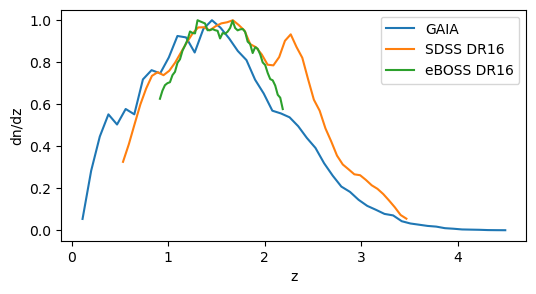

In [10]:
pl.figure(figsize=(6,3))
pl.plot(dndz[0],dndz[1]/dndz[1].max(),label='GAIA')
pl.plot(dndz_sdss[0],dndz_sdss[1]/dndz_sdss[1].max(),label='SDSS DR16')
pl.plot(dndz_eboss[0],dndz_eboss[1]/dndz_eboss[1].max(),label='eBOSS DR16')
pl.xlabel("z")
pl.ylabel("dn/dz")
pl.legend()
pl.show()

# Theory calculation

Defines relevant quantities for calculations.

### b(z) models

In [11]:
# Measured bias from SDSS,  includes data and error of Shen+2008 
# (https://iopscience.iop.org/article/10.1088/0004-637X/697/2/1656/pdf)
#The positive points include only non-negative data points in the fit from correlation function.
# data are in the format z,b,b_error
from scipy import interpolate

bz_qso_th_positive = np.array([[0.50,1.32 ,0.17 ],[1.13 ,2.31 ,0.22],[1.68,2.96 ,0.26 ],[2.18,4.69 ,0.70 ],
                               [3.17,7.76 ,1.44 ],[3.84,12.96,2.09 ]])
bz_qso_th = np.array([[0.50,1.32,0.17 ],[1.13 ,2.20,0.23 ],[1.68 ,2.49,0.27 ],[2.18 ,3.29,0.79 ],
                      [3.17,7.10,1.48],[3.84,9.85,2.27]])

#bz_sdss = interpolate.interp1d(bz_qso_th[:,0],bz_qso_th[:,1],fill_value=(0.,0.),bounds_error=False)
bz_sdss = interpolate.interp1d(bz_qso_th[:,0],bz_qso_th[:,1],fill_value='extrapolate',bounds_error=False)


# Photometric model in agreement with Sherwin+2012 and Leisted+2015
def bz_sdss_photo(z):
    return 1+((1+z)/2.5)**5

### Scale dependent bias model $b(k,z)$

In [14]:

nz = 100 #number of steps to use for the radial/redshift integration
kmax=10  #kmax to use
#First set up parameters as usual
pars = init_pars()

results_bg= camb.get_background(pars)
chistar = results_bg.conformal_time(0)- results_bg.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results_bg.redshift_at_comoving_radial_distance(chis)
pars.set_matter_power(redshifts=zs, kmax=kmax)
results= camb.get_results(pars)
trans = results.get_matter_transfer_data()

#k_trans = get kh - the values of k/h at which they are calculated and convert to k
kh = trans.transfer_data[0,:,-1] # note earliest redshift first
k = kh/pars.h
delta = trans.transfer_data[model.Transfer_tot-1,:,-1]
delta = np.interp(kh/pars.h,kh,delta)
Tk = interpolate.interp1d(k,delta/delta[0],fill_value='extrapolate',bounds_error=False)

Dz = interpolate.interp1d(zs,results.get_sigma8()[::-1]/results.get_sigma8_0(),fill_value='extrapolate',bounds_error=False)

def Om(z):
    #Om = (pars.omnuh2+pars.omch2+pars.ombh2)/pars.h**2
    return results.get_Omega('nu',z)+results.get_Omega('baryon',z)+results.get_Omega('cdm',z)

delta_c = 1.686
c = const.c.to('km/s').value



def b_g(z,bz_model=bz_sdss):
    b_g_z = bz_model(z)
    b_g_z[b_g_z<1.]=1.
    return b_g_z

def b_phi(z,bz_model=bz_sdss):
    return delta_c*(b_g(z,bz_model) - 1)

def db_g(z,k,fNL=1.,z_pivot=0,bz_model=bz_sdss):
    # results.h_of_z gives H0(z)/c 
    return fNL*3*Om(z_pivot)*(results.h_of_z(z_pivot))**2*b_phi(z,bz_model)/(Dz(z)*Tk(k)*k**2)

def b_h(z,k,fNL=1,z_pivot=0,bz_model=bz_sdss):
    b_h = b_g(z,bz_model)+db_g(z,k,fNL,z_pivot,bz_model)
    return b_h

#b_h = b_g + fNL*3*Om*(pars.H0/c)**2*b_phi/(Dz(zs)*Tk*k**2)


Note: redshifts have been re-sorted (earliest first)


GAIA median bias 2.367640563636364 at z_median=1.448
GAIA median bias photo 1.9001251865393416 at z_median=1.448



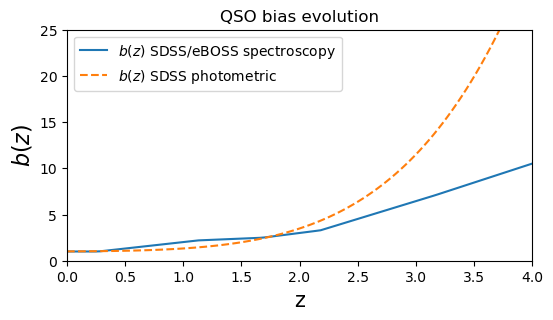

In [34]:
print("GAIA median bias",bz_sdss(zmed),"at z_median=%.3f"%zmed)
print("GAIA median bias photo",bz_sdss_photo(zmed),"at z_median=%.3f\n"%zmed)
zs=np.linspace(0,4,100)
pl.figure(figsize=(6,3))
pl.plot(zs,b_g(zs),label='$b(z)$ SDSS/eBOSS spectroscopy')
pl.plot(zs,b_g(zs,bz_sdss_photo),label='$b(z)$ SDSS photometric',ls='--')
pl.xlim(0,4)
pl.ylim(0,25)
pl.xlabel("z",size=15)
pl.ylabel("$b(z)$",size=16)
pl.title("QSO bias evolution")
pl.legend()
pl.show()

### Interpolators and integrals in Limber

In [16]:
# see also CAMB example notebook

nz = 100 #number of steps to use for the radial/redshift integration
kmax=100  #kmax to use
kmin=1e-06#kmin to use

#First set up parameters
pars = init_pars()

#For Limber result, want integration over \chi (comoving radial distance), from 0 to chi_*.
#so get background results to find chistar, set up a range in chi, and calculate corresponding redshifts
results= camb.get_background(pars)
chistar = results.conformal_time(0)- results.tau_maxvis
chis = np.linspace(0,chistar,nz)
zs=results.redshift_at_comoving_radial_distance(chis)

#Calculate array of delta_chi, and drop first and last points where things go singular
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]

pars.set_matter_power(redshifts=zs, kmax=kmax)
results= camb.get_background(pars)

#Get the matter power spectrum interpolation object (based on RectBivariateSpline).

PK = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zs[-1])

PKm = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_tot,var2=model.Transfer_tot, zmax=zs[-1])

Note: redshifts have been re-sorted (earliest first)


Computes once and for all the CMB lensing convergence power spectra

In [17]:
#Get lensing window function (flat universe)
win = ((chistar-chis)/(chis**2*chistar))**2
#Do integral over chi
ls = np.arange(2,2500+1, dtype=np.float64)
cl_kappa=np.zeros(ls.shape)
cl_kappa_2=np.zeros(ls.shape)

w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<kmin]=0
    w[k>=kmax]=0
    cl_kappa[i] = np.dot(dchis, w*PK.P(zs, k, grid=False)*win/k**4)
    
    # computes the same quantity from the matter power spectrum
    prefac=3*0.5*(Om(zs))*(results.h_of_z(zs)/(1+zs))**2
    cl_kappa_2[i] = np.dot(dchis, w*PKm.P(zs, k, grid=False)*win*prefac**2/k**4)
    
cl_kappa*= (ls*(ls+1))**2
cl_kappa_2*= (ls*(ls+1))**2

# Forecasts results

Define function used to compute Limber predictions of $C_\ell^{kg},C_\ell^{gg},C_\ell^{kk}$ and their derivatives. We assume limber approximation and consider

$$ C_\ell^{\kappa g} = \int \frac{d\chi}{\chi^2} b_h(k,z)\frac{dn}{dz}\frac{dz}{d\chi}\left(\frac{\chi-\chi_{*}}{\chi\chi_*}\right)P_{mm}\left(\frac{\ell+0.5}{\chi},\chi\right)$$
$$ C_\ell^{g g} = \int \frac{d\chi}{\chi^2} \left(b_h(k,z)\frac{dn}{dz}\frac{dz}{d\chi}\right)^2P_{mm}\left(\frac{\ell+0.5}{\chi},\chi\right)$$

$$ C_\ell^{\kappa\kappa} = \int \frac{d\chi}{\chi^2} \left(\frac{\chi-\chi_{*}}{\chi\chi_*}\right)^2P_{\psi\psi}\left(\frac{\ell+0.5}{\chi},\chi\right) = \int \frac{d\chi}{\chi^2} \frac{9\Omega_m(\chi)^2H(\chi)^4}{4c^2}\left(\frac{\chi-\chi_{*}}{\chi\chi_*}\right)^2P_{mm}\left(\frac{\ell+0.5}{\chi},\chi\right) =  $$

In [18]:
def get_clkg(bias_func,dndz_func,fNL=1.,lmax=2500,bz_model=bz_sdss):
    #Do integral over chi
    ls = np.arange(2,lmax+1, dtype=np.float64)
    cl_kg=np.zeros(ls.shape)
    w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        win = (bias_func(zs,k,fNL=fNL,bz_model=bz_model)*dndz_func(zs)*results.h_of_z(zs))*((chistar-chis)/(chis**3*chistar))        
        w[:]=1
        w[k<kmin]=0
        w[k>=kmax]=0
        prefac=3*0.5*Om(zs)*(results.h_of_z(zs)/(1+zs))**2
        cl_kg[i] = np.dot(dchis, w*PKm.P(zs, k, grid=False)*win*prefac/k**2)
    cl_kg*= ls*(ls+1)
    return cl_kg

def get_clgg(bias_func,dndz_func,fNL=1.,lmax=2500,bz_model=bz_sdss):
    #Do integral over chi
    ls = np.arange(2,lmax+1, dtype=np.float64)
    cl_gg=np.zeros(ls.shape)
    w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        win = (bias_func(zs,k,fNL=fNL,bz_model=bz_model)*dndz_func(zs)*results.h_of_z(zs)/chis**1)**2
        w[:]=1
        w[k<kmin]=0
        w[k>=kmax]=0
        prefac=1
        cl_gg[i] = np.dot(dchis, w*PKm.P(zs, k, grid=False)*win)
    return cl_gg


def get_dclkg_dfnl(bias_func,dndz_func,fNL=1.,lmax=2500,bz_model=bz_sdss):
    return get_clkg(bias_func,dndz_func,1,lmax=lmax,bz_model=bz_model)

def get_dclgg_dfnl(dbias_func_dfNL,dndz_func,fNL=1.,lmax=2500,bz_model=bz_sdss):
    #Do integral over chi
    ls = np.arange(2,lmax+1, dtype=np.float64)
    cl_dgg_dfnl=np.zeros(ls.shape)
    w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        win = dbias_func_dfNL(zs,k,fNL=fNL,bz_model=bz_model)*(dndz_func(zs)*results.h_of_z(zs)/chis)**2
        w[:]=1
        w[k<kmin]=0
        w[k>=kmax]=0
        prefac=1
        cl_dgg_dfnl[i] = np.dot(dchis, w*PKm.P(zs, k, grid=False)*win*prefac)
    return cl_dgg_dfnl

def db2_h_dfNL(z,k,fNL=1,z_pivot=0,bz_model=bz_sdss):
    return 2*b_h(z,k,fNL,z_pivot,bz_model=bz_model)*db_g(z,k,1,z_pivot,bz_model=bz_model)

We define the Fisher matrix with a single integrated bin following Schmittfull & Seljak 2018 (https://arxiv.org/pdf/1710.09465.pdf). Assuming $\rho_\ell$ the cross-correlation coefficient between g and $\kappa$ we have
$$ \sigma(f_{NL}) = 1/\sqrt{F_{f_{NL}f_{NL}}}$$
$$ F_{f_{NL}f_{NL}} = \sum_{\ell}(2\ell+1)f_{sky}F_{f_{NL}f_{NL},\ell}$$
$$ F_{f_{NL}f_{NL},\ell} = \frac{1}{2(1-\rho_\ell^2)^2}\left[\left(\frac{\partial_{f_{NL}}C^{gg}_\ell}{\hat{C}^{gg}_\ell}\right)^2 -4\rho_\ell^2\frac{\partial_{f_{NL}}C^{gg}_\ell}{\hat{C}^{gg}_\ell}\frac{\partial_{f_{NL}}C^{kg}_\ell}{C^{kg}_\ell} +2\rho_\ell^2(1+\rho_\ell^2)\left(\frac{\partial_{f_{NL}}C^{kg}_\ell}{C^{kg}_\ell}\right)^2  \right] $$

In [19]:
def compute_fisher_schmittfull(interp_dndz,fsky,shot_noise,lmin=2,lmax=1000,fNL_th=0.,bz_model=bz_sdss):
    #shot_noise =  hp.nside2resol(256)**2*1/nbar
    ls_fisher = np.arange(lmin,lmax+1)
    cl_gg_th = get_clgg(b_h,interp_dndz,fNL=fNL_th,lmax=lmax,bz_model=bz_model)[lmin-2:]
    cl_kg_th = get_clkg(b_h,interp_dndz,fNL=fNL_th,lmax=lmax,bz_model=bz_model)[lmin-2:]
    
    dclkg_dfnl = get_dclkg_dfnl(db_g,interp_dndz,fNL=fNL_th,lmax=lmax,bz_model=bz_model)[lmin-2:]  
    
    dclgg_dfnl = get_dclgg_dfnl(db2_h_dfNL,interp_dndz,fNL=fNL_th,lmax=lmax,bz_model=bz_model)[lmin-2:]
        
    cl_gg_data = cl_gg_th + shot_noise
    cl_kk_data = clkk[lmin:lmax+1]
    cl_kk_th = cl_kappa[lmin-2:lmax-1]
    
    rho_l = cl_kg_th/np.sqrt(cl_gg_data*cl_kk_data)
    rho_l_th = cl_kg_th/np.sqrt(cl_gg_th*cl_kk_th)
    
    fisher_gg = (dclgg_dfnl/cl_gg_data)**2
    fisher_kggg  = -4*rho_l**2*np.sqrt(fisher_gg)*(dclkg_dfnl/cl_kg_th)
    fisher_kg = 2*rho_l**2*(1+rho_l**2)*(dclkg_dfnl/cl_kg_th)**2
    
    fisher_tot = (2*ls[lmin:lmax+1]+1)*fsky*(fisher_gg+fisher_kggg+fisher_kg)/(2*(1-rho_l**2)**2)
    
    # equivalent formula from Schmittfull & Seljak paper
    #fisher_tot2 = (2*ls[lmin:lmax+1]+1)*fsky*(((dclgg_dfnl/cl_gg_data) - 2*rho_l**2*(dclkg_dfnl/cl_kg_th))**2
    #                                         + 2*rho_l**2*(1-rho_l**2)*(dclkg_dfnl/cl_kg_th)**2)/(2*(1-rho_l**2)**2)
    
    fisher_cross = (2*ls[lmin:lmax+1]+1)*fsky*(dclkg_dfnl**2/(cl_gg_data*cl_kk_data+cl_kg_th**2))
    fisher_auto = (2*ls[lmin:lmax+1]+1)*fsky*fisher_gg/2
    return ([fisher_tot,fisher_cross,fisher_auto],[ls_fisher,cl_gg_th,cl_kg_th,cl_kk_th,dclgg_dfnl,dclkg_dfnl,cl_kk_data,
                                                   cl_gg_data,rho_l])

We will use both $b(z)$ model and the spec of the surveys and assume $f_{NL}=0$

In [21]:
fNL_th=0.

In [22]:
# gaia specs

lmax=1000
lmin=2
fsky = 0.5
nbar = 1.22
shot_noise =  hp.nside2resol(256)**2*1/nbar


(fisher_gaia,cls_fisher_gaia)= compute_fisher_schmittfull(interp_dndz_gaia,fsky,
                                                            shot_noise,lmin=lmin,lmax=lmax,fNL_th=fNL_th)

(fisher_gaia_photo,cls_fisher_gaia_photo)= compute_fisher_schmittfull(interp_dndz_gaia,fsky,shot_noise,lmin=lmin,
                                                            lmax=lmax,fNL_th=fNL_th,bz_model=bz_sdss_photo)


print("Gaia    QSO lmin %d lmax %d tot/cross/auto"%(lmin,lmax),1/np.sqrt(np.sum(fisher_gaia[0])),1/np.sqrt(np.sum(fisher_gaia[1])),
      1/np.sqrt(np.sum(fisher_gaia[2])))

print("Gaia    QSO lmin %d lmax %d tot/cross/auto photo_bz"%(lmin,lmax),1/np.sqrt(np.sum(fisher_gaia_photo[0])),
      1/np.sqrt(np.sum(fisher_gaia_photo[1])),
      1/np.sqrt(np.sum(fisher_gaia_photo[2])))



Gaia    QSO lmin 2 lmax 1000 tot/cross/auto 17.547787210555192 18.853725737557205 38.934470821728574
Gaia    QSO lmin 2 lmax 1000 tot/cross/auto photo_bz 14.844528094319108 16.150133606622035 29.99350839225064


In [23]:
lmin_sdss=2
lmax_sdss=1000

#nbar_sdss = 0.515853456439394 
nbar_sdss = 0.8250456518743109  # on eBOSS footprint
shot_noise_sdss =  hp.nside2resol(512)**2*1/nbar_sdss
#fsky_sdss = 0.2685546875
fsky_sdss = 0.14762369791666666 # on eBOSS footprint



(fisher_sdss_photo,cls_fisher_sdss_photo)= compute_fisher_schmittfull(interp_dndz_sdss,fsky_sdss,shot_noise_sdss,
                                                            lmin=lmin_sdss,lmax=lmax_sdss,fNL_th=fNL_th,
                                                            bz_model=bz_sdss_photo)

(fisher_sdss_photo_all,cls_fisher_sdss_photo_all)= compute_fisher_schmittfull(interp_dndz_sdss_all,fsky_sdss,
                                                            shot_noise_sdss,lmin=lmin_sdss,lmax=lmax_sdss,
                                                            fNL_th=fNL_th,bz_model=bz_sdss_photo)

print("SDSS16 QSO lmin %d lmax %d tot/cross/auto"%(lmin_sdss,lmax_sdss),1/np.sqrt(np.sum(fisher_sdss_photo[0])),
      1/np.sqrt(np.sum(fisher_sdss_photo[1])),
      1/np.sqrt(np.sum(fisher_sdss_photo[2])))

print("SDSS16 QSO lmin %d lmax %d tot/cross/auto photo_bz"%(lmin_sdss,lmax_sdss),
      1/np.sqrt(np.sum(fisher_sdss_photo_all[0])),
      1/np.sqrt(np.sum(fisher_sdss_photo_all[1])),
      1/np.sqrt(np.sum(fisher_sdss_photo_all[2])))


SDSS16 QSO lmin 2 lmax 1000 tot/cross/auto 9.265478418763143 14.219112101063883 10.806867466730171
SDSS16 QSO lmin 2 lmax 1000 tot/cross/auto photo_bz 9.192950146794308 12.794410364220317 11.290509451951557


In [24]:
#eBOSS DR16
lmin_eboss=2
lmax_eboss=1000
fsky_eboss =0.14762369791666666
nbar_eboss =0.7051922546857773
shot_noise_eboss =  hp.nside2resol(512)**2*1/nbar_eboss

#eBOSS DR14
lmin_eboss14=2
lmax_eboss14=1000
fsky_eboss14 =0.077880859375
nbar_eboss14 =0.5796801528213166
shot_noise_eboss14 =  hp.nside2resol(512)**2*1/nbar_eboss14


(fisher_eboss,cls_fisher_eboss)= compute_fisher_schmittfull(interp_dndz_gaia,fsky_eboss,shot_noise_eboss,
                                                            lmin=lmin_eboss,lmax=lmax_eboss,fNL_th=fNL_th)

(fisher_eboss14,cls_fisher_eboss14)= compute_fisher_schmittfull(interp_dndz_gaia,fsky_eboss14,shot_noise_eboss14,
                                                            lmin=lmin_eboss14,lmax=lmax_eboss14,fNL_th=fNL_th)

print("eBOSS16 QSO lmin %d lmax %d tot/cross/auto"%(lmin_eboss,lmax_eboss),1/np.sqrt(np.sum(fisher_eboss[0])),
      1/np.sqrt(np.sum(fisher_eboss[1])),1/np.sqrt(np.sum(fisher_eboss[2])))

print("eBOSS14 QSO lmin %d lmax %d tot/cross/auto"%(lmin_eboss,lmax_eboss),1/np.sqrt(np.sum(fisher_eboss14[0])),
      1/np.sqrt(np.sum(fisher_eboss14[1])),1/np.sqrt(np.sum(fisher_eboss14[2])))


eBOSS16 QSO lmin 2 lmax 1000 tot/cross/auto 20.536262540380676 23.92827764128861 32.96925427951035
eBOSS14 QSO lmin 2 lmax 1000 tot/cross/auto 31.493092489162965 35.822438735898885 54.196221107187775


# Summary 



* Due to its low QSO density Gaia constraints are dominated by the $\kappa g$ spectrum. 
* SDSS DR16 photometric total has potentially the higher constraining power although the majority of the objects are located in the eBOSS footprint which is much smaller but has a migher density of target. While Gaia has the potential to use a bin at $2<\ell<20$ with limited systematics, it is unlikely that SDSS will be able to use scales much larger than 30 from our previous study. Deprojection might also be needed. 
* We therefore can get comparable results from a simple analysis with the Gaia sample. 
* There are some differences in the results depending on which sample b(z) model we're using. With Gaia we could probably also fit easily the bias from the auto spectrum even starting at $\ell>30$ where the systematics seem low. 

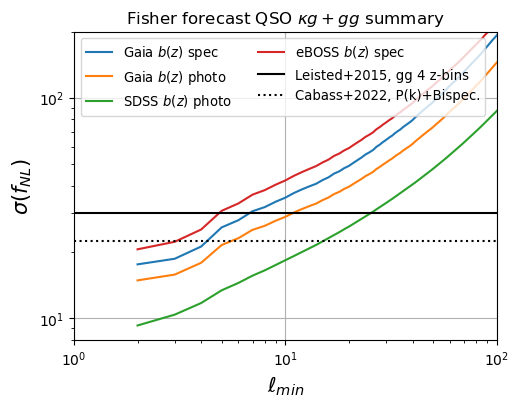

In [25]:
pl.figure(figsize=(12,4))
pl.subplot(121)
lmins = lmin+np.arange(998)
pl.loglog(lmins,[1/np.sqrt(np.sum(fisher_gaia[0][lmin_i-lmin:])) for lmin_i in lmins],label='Gaia $b(z)$ spec')
pl.loglog(lmins,[1/np.sqrt(np.sum(fisher_gaia_photo[0][lmin_i-lmin:])) for lmin_i in lmins],label='Gaia $b(z)$ photo')
pl.loglog(lmins,[1/np.sqrt(np.sum(fisher_sdss_photo[0][lmin_i-lmin:])) for lmin_i in lmins],label='SDSS $b(z)$ photo')
pl.loglog(lmins,[1/np.sqrt(np.sum(fisher_eboss[0][lmin_i-lmin:])) for lmin_i in lmins],label='eBOSS $b(z)$ spec')
pl.axhline(30,ls='-',color='black',label="Leisted+2015, gg 4 z-bins")
#pl.axhline(28,ls='--',color='black',label="Cabass+2022, 3D P(k) EFT BOSS")
pl.axhline(28*0.8,ls=':',color='black',label="Cabass+2022, P(k)+Bispec.")
pl.xlabel("$\ell_{min}$",size=15)
pl.ylabel("$\sigma(f_{NL})$",size=15)
pl.legend(loc='upper left',ncol=2,fontsize=9.5)
pl.ylim(8,200)
pl.xlim(1,100)
pl.grid()
pl.title("Fisher forecast QSO $\kappa g + gg$ summary")
pl.show()

In [26]:
def plot_fnl_summary(fisher_matrix,title='Gaia'):
    fisher_tot=fisher_matrix[0]
    fisher_cross=fisher_matrix[1]
    fisher_auto=fisher_matrix[2]    
    pl.figure(figsize=(12,4))
    pl.subplot(121)
    lmins = lmin+np.arange(998)
    pl.loglog(lmins,[1/np.sqrt(np.sum(fisher_tot[lmin_i-lmin:])) for lmin_i in lmins],label='$\kappa g+ gg$')
    pl.loglog(lmins,[1/np.sqrt(np.sum(fisher_cross[lmin_i-lmin:])) for lmin_i in lmins],label='$\kappa g$')
    pl.loglog(lmins,[1/np.sqrt(np.sum(fisher_auto[lmin_i-lmin:])) for lmin_i in lmins],label='$gg$')
    pl.axhline(30,ls='-',color='black',label="Leisted+2015, 4 z-bins, $\ell_{max}=190$")
    pl.axhline(28,ls='--',color='black',label="Cabass+2022, 3D P(k) EFT BOSS")
    pl.axhline(28*0.8,ls=':',color='black',label="Cabass+2022, +Bispec.")
    pl.xlabel("$\ell_{min}$",size=15)
    pl.ylabel("$\sigma(f_{NL})$",size=15)
    pl.legend(loc='upper left',ncol=2,fontsize=10)
    pl.ylim(10,200)
    pl.xlim(1,100)
    pl.grid()
    pl.title("Fisher forecast QSO %s $\ell_{max}=500$"%title)
    
    pl.subplot(122)
    lmaxs = lmin+1+np.arange(998)
    pl.loglog(lmaxs,[1/np.sqrt(np.sum(fisher_tot[:lmax_i+1])) for lmax_i in lmaxs],label='$\kappa g+ gg$')
    pl.loglog(lmaxs,[1/np.sqrt(np.sum(fisher_cross[:lmax_i+1])) for lmax_i in lmaxs],label='$\kappa g$')
    pl.loglog(lmaxs,[1/np.sqrt(np.sum(fisher_auto[:lmax_i+1])) for lmax_i in lmaxs],label='$gg$')
    pl.axhline(30,ls='-',color='black',label="Leisted+2015, 4 z-bins, $\ell_{max}=190$")
    pl.axhline(28,ls='--',color='black',label="Cabass+2022, 3D P(k) EFT BOSS")
    pl.axhline(28*0.8,ls=':',color='black',label="Cabass+2022, +Bispec.")
    pl.xlabel("$\ell_{max}$",size=15)
    pl.ylabel("$\sigma(f_{NL})$",size=15)
    pl.legend(loc='upper left',ncol=2,fontsize=10)
    pl.ylim(10,200)
    pl.xlim(1,500)
    pl.grid()
    pl.title("Fisher forecast QSO %s $\ell_{min}=2$"%title)
    pl.show()


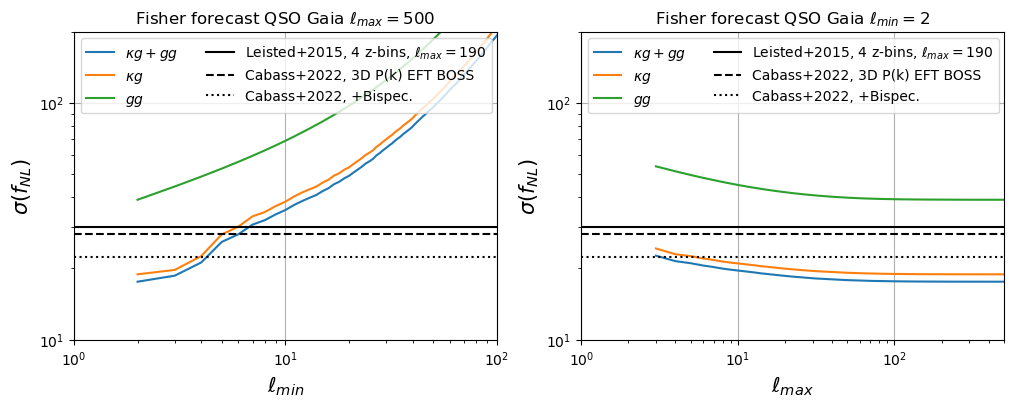

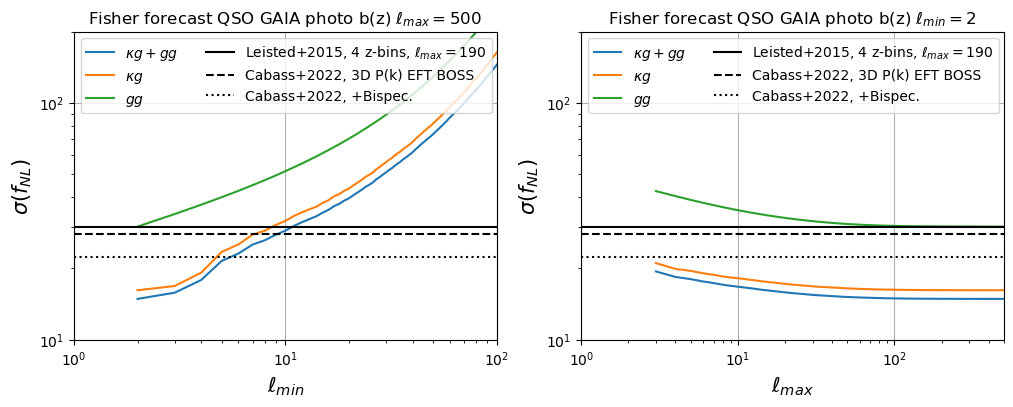

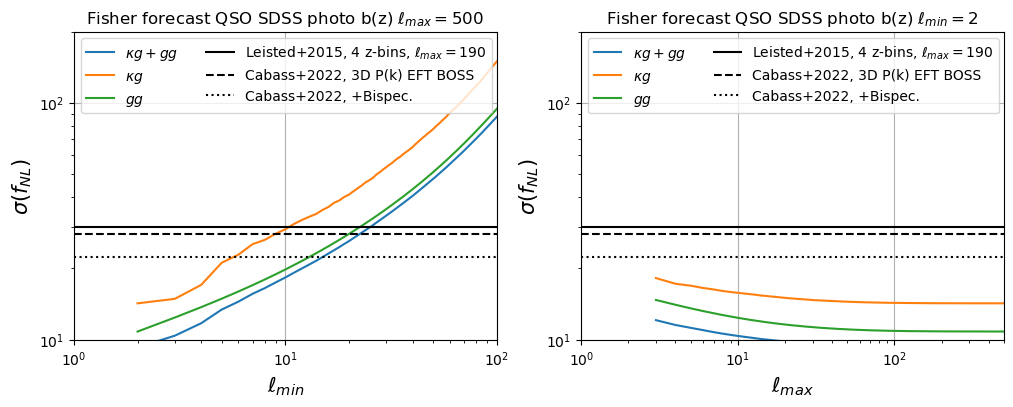

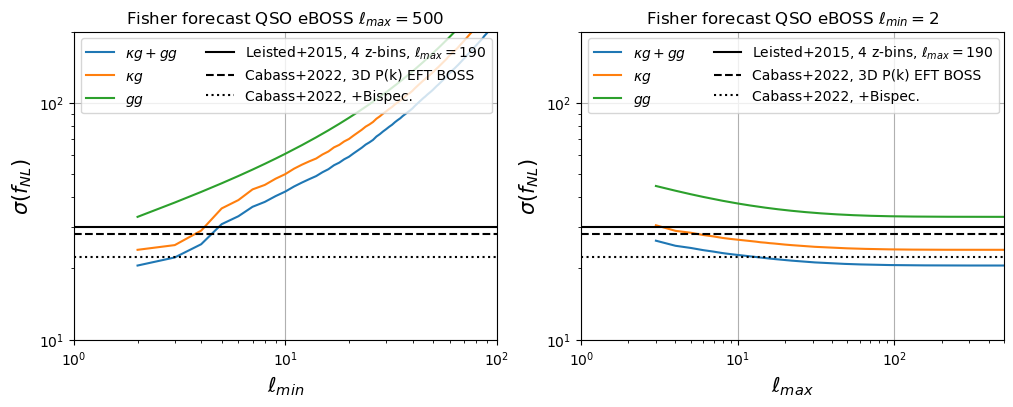

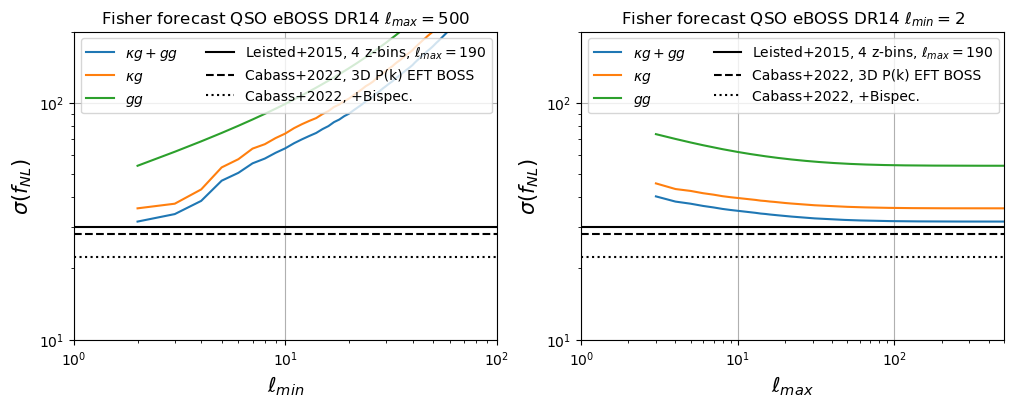

In [27]:
plot_fnl_summary(fisher_gaia)
plot_fnl_summary(fisher_gaia_photo,'GAIA photo b(z)')
plot_fnl_summary(fisher_sdss_photo,'SDSS photo b(z)')
plot_fnl_summary(fisher_eboss,'eBOSS')
plot_fnl_summary(fisher_eboss14,'eBOSS DR14')

# Accuracy of theory predictions

Check definitions used in the above work and accuracy of Limber approximation.

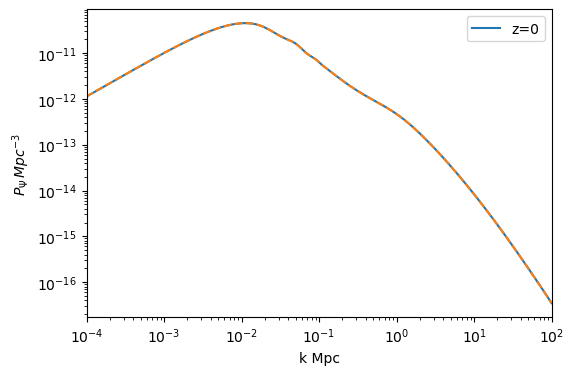

In [28]:
#Have a look at interpolated power spectrum results for a range of redshifts
#Expect linear potentials to decay a bit when Lambda becomes important, and change from non-linear growth
pl.figure(figsize=(6,4))
k=np.exp(np.log(10)*np.linspace(-4,2,200))
zplot = [0]#, 0.5, 1, 4 ,20]
for z in zplot:
    pl.loglog(k, PKm.P(z,k)*9*0.25*(Om(z)**2*results.h_of_z(z)**4)) #power spectrrum of delta 
    pl.loglog(k, PK.P(z,k),ls='--') # it's the power spectrum of k^2\psi
    # normally P_\psi = 9/4 * Om^2*H^4/c^4 P_m/k^4 \equiv gamma(z)*P_\delta/k^4 but in this case the k factor
    # is reabsorbed in the definition of \Psi
pl.xlim([1e-4,kmax])
pl.xlabel('k Mpc')
pl.ylabel('$P_\Psi\, Mpc^{-3}$')
pl.legend(['z=%s'%z for z in zplot]);

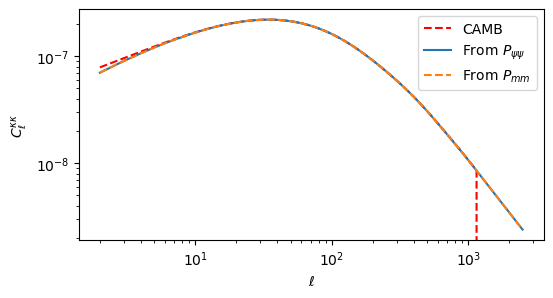

In [29]:
# check agreement between methods
pl.figure(figsize=(6,3))
results = camb.get_results(pars)
cl_camb=results.get_lens_potential_cls(2500) 
pl.loglog(np.arange(2,cl_camb[:,0].size),cl_camb[2:,0]*np.pi/2, color='r',ls='--',label='CAMB')

pl.loglog(ls,cl_kappa,label='From $P_{\psi\psi}$')
pl.loglog(ls,cl_kappa_2,ls='--',label='From $P_{mm}$')
pars.set_for_lmax(2500,lens_potential_accuracy=2)
pl.ylabel("$C_\ell^{\kappa\kappa}$")
pl.xlabel("$\ell$")
pl.legend()
pl.show()


In [30]:
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
#NonLinear_both or NonLinear_lens will use non-linear corrections
z_mean = 0.17
sigma_z = 0.04
b = 1.2
pars.NonLinear = model.NonLinear_both
#Set up W(z) window functions, later labelled W1, W2. Gaussian here.
pars.SourceWindows = [GaussianSourceWindow(redshift=z_mean, source_type='counts', bias=b, sigma=sigma_z)]
results = camb.get_results(pars)
cmb = results.get_cmb_power_spectra(raw_cl=True,CMB_unit='muK')

cls = results.get_source_cls_dict(raw_cl=True)
lcamb = np.arange(len(cls['PxP']))


In [31]:
#Get gg integral with a gassian window as above
# results.h_of_z(zs) = dz/dchi
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

win = (b*gaussian(zs,z_mean,sigma_z)*results.h_of_z(zs)/chis**1)**2#*((chistar-chis)/(chis**3*chistar))
#Do integral over chi
ls = np.arange(2,2500+1, dtype=np.float64)
cl_gg=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<kmin]=0
    w[k>=kmax]=0
    prefac=1#3*0.5*(results.get_Omega('cdm',zs)+results.get_Omega('baryon',zs))*(results.h_of_z(zs)/(1+zs))**2
    cl_gg[i] = np.dot(dchis, w*PKm.P(zs, k, grid=False)*win*prefac/k**0)

In [32]:
#Get lensing-g cross-correlation
# results.h_of_z(zs) = dz/dchi
win = (b*gaussian(zs,z_mean,sigma_z)*results.h_of_z(zs))*((chistar-chis)/(chis**3*chistar))
#Do integral over chi
ls = np.arange(2,2500+1, dtype=np.float64)
cl_kg=np.zeros(ls.shape)
w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
for i, l in enumerate(ls):
    k=(l+0.5)/chis
    w[:]=1
    w[k<kmin]=0
    w[k>=kmax]=0
    prefac=3*0.5*Om(zs)*(results.h_of_z(zs)/(1+zs))**2
    cl_kg[i] = np.dot(dchis, w*PKm.P(zs, k, grid=False)*win*prefac/k**2)
cl_kg*= ls*(ls+1)

/var/folders/km/20v3lwvj1ndcxk8tbr8sgnt40000gq/T/ipykernel_44592/1553786727.py:3: RuntimeWarning: divide by zero encountered in divide
  d2p=1/p2d


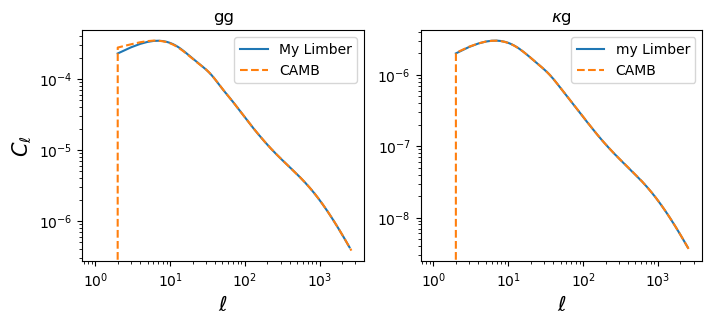

In [33]:
# plots power spectra
p2d=np.sqrt(lcamb*(lcamb+1))
d2p=1/p2d
d2p[0:2]=0.0
d2k=p2d/2
p2k=(p2d**2/2)

pl.figure(figsize=(8,3))
pl.subplot(121)
rescale=1#(cls['W1xW1'][2])/cl_gg[0]
pl.loglog(ls,cl_gg*rescale,label='My Limber')
pl.loglog(lcamb,cls['W1xW1'],ls='--',label='CAMB')
pl.legend()
pl.title("gg",size=12)
pl.xlabel("$\ell$",size=15)
pl.ylabel("$C_\ell$",size=15)
pl.subplot(122)
rescale=1#(cls['W1xP'][2]*p2k[2])/cl_kg[0]
pl.loglog(ls,cl_kg,label='my Limber')
pl.loglog(lcamb,cls['W1xP']*p2k,ls='--',label='CAMB')
pl.legend()
pl.title("$\kappa$g",size=12)
pl.xlabel("$\ell$",size=15)
pl.show()